In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# zapobieganie wypisywania notacji naukowej przez numpy
np.set_printoptions(suppress=True)

https://stat.gov.pl/obszary-tematyczne/ceny-handel/wskazniki-cen/wskazniki-cen-towarow-i-uslug-konsumpcyjnych-pot-inflacja-/miesieczne-wskazniki-cen-towarow-i-uslug-konsumpcyjnych-od-1982-roku/

# Zbieranie i przygotowanie danych

### Załadowanie pliku z google drive

In [3]:
### Załadowanie dysku
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# data_file = "/content/drive/My Drive/Colab Notebooks/miesieczne_wskazniki_cen_towarow_i_uslug_konsumpcyjnych_od_1982_roku.xlsx"

### Załadowanie pliku z dysku

In [5]:
from google.colab import files
uploaded = files.upload()
data_file = list(uploaded.keys())[0]

Saving miesieczne_wskazniki_cen_towarow_i_uslug_konsumpcyjnych_od_1982_roku.xlsx to miesieczne_wskazniki_cen_towarow_i_uslug_konsumpcyjnych_od_1982_roku.xlsx


### Filtracja danych

In [6]:
try:
  df = pd.read_excel(data_file)
  if "Sposób prezentacji" in df.columns:
      # Filtrowanie danych
      df_poprzedni_miesiac_100 = df[df["Sposób prezentacji"] == "Poprzedni miesiąc = 100"].copy()

      print("Wczytano dane i przefiltrowano według 'Sposób prezentacji' = 'Poprzedni miesiąc=100'.")
  else:
      print("Kolumna 'Sposób prezentacji' nie została znaleziona w pliku Excel.")
except FileNotFoundError:
    print(f"Błąd: Plik nie znaleziony pod ścieżką {data_file}")
except Exception as e:
    print(f"Wystąpił błąd podczas wczytywania pliku: {e}")

Wczytano dane i przefiltrowano według 'Sposób prezentacji' = 'Poprzedni miesiąc=100'.


In [7]:
# TODO: sprawdz co oznacza Flaga 'a' w roku 2000 i 2001
#df_poprzedni_miesiac_100[["Sposób prezentacji", "Rok", "Miesiąc", "Wartość", "Flaga"]]
data = df_poprzedni_miesiac_100[["Rok", "Miesiąc", "Wartość"]]
# pozbywamy się wierszy z wartościami NaN, występujące w roku 2025
data = data.dropna(subset=["Wartość"])
data = data.sort_values(by=['Rok','Miesiąc'], ascending=[1,1])

data_array = data.to_numpy()

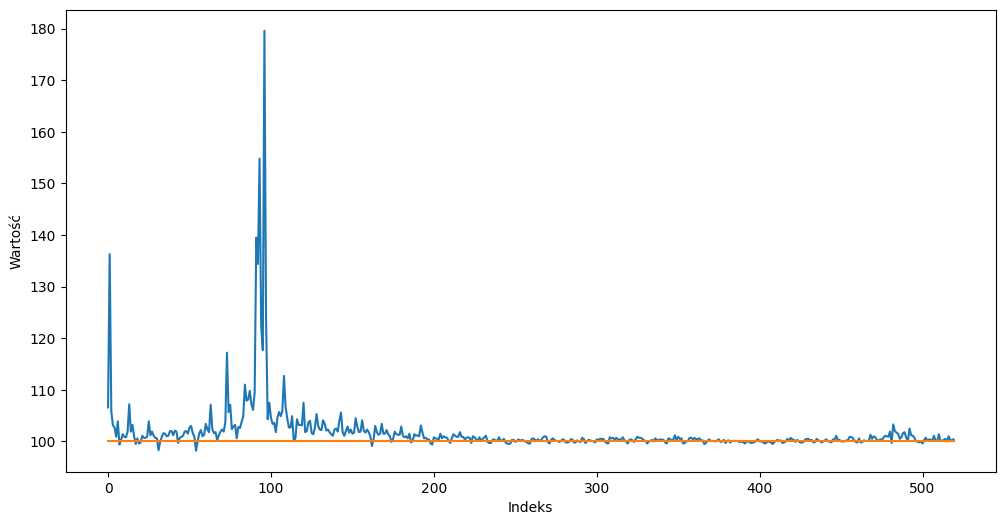

In [8]:
data_array_numpy = np.array(data_array)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(data_array_numpy)), data_array_numpy[:,2])
ax.plot(np.arange(len(data_array_numpy)), np.full(len(data_array_numpy), 100))
ax.set_xlabel("Indeks")
ax.set_ylabel("Wartość")
plt.show()

# nie wiem czy to dobry pomysł - tracimy sekwencyjność

In [9]:
mean = np.mean(data_array[:, 2:3], axis=0)
sd = np.std(data_array[:, 2:3], axis=0)
top_limit = mean + 3 * sd
bottom_limit = mean - 3 * sd

# wypiszmy dane, które zostaną usunięte (outliery)
for row in data_array:
  if (row[2] <= bottom_limit) or (row[2] >= top_limit):
    print(row)

data_array = [row for row in data_array if (row[2] > bottom_limit)]
data_array = [row for row in data_array if (row[2] < top_limit)]

[1982.     2.   136.3]
[1989.     8.   139.5]
[1989.     9.   134.4]
[1989.    10.   154.8]
[1989.    11.   122.4]
[1990.     1.   179.6]
[1990.     2.   123.8]


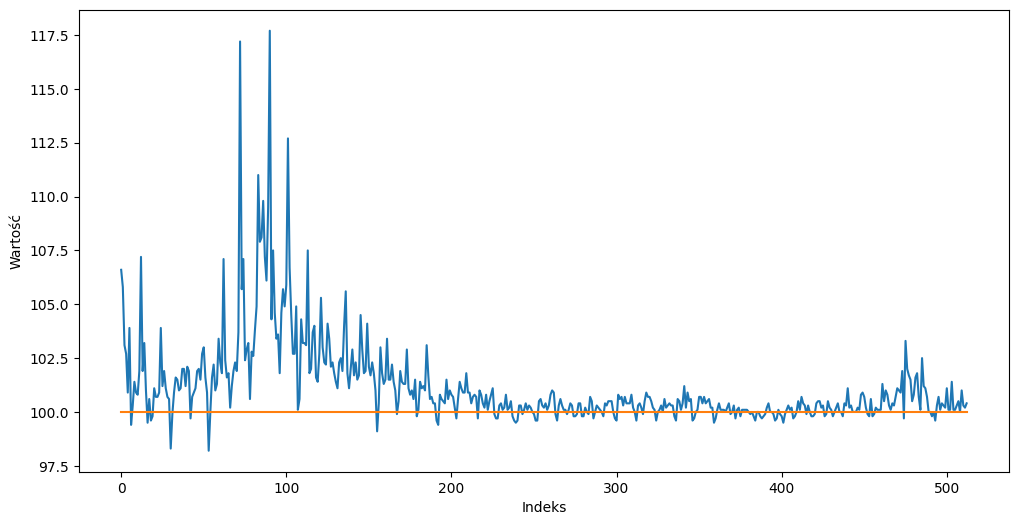

In [10]:
data_array_numpy = np.array(data_array)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(data_array_numpy)), data_array_numpy[:,2])
ax.plot(np.arange(len(data_array_numpy)), np.full(len(data_array_numpy), 100))
ax.set_xlabel("Indeks")
ax.set_ylabel("Wartość")
plt.show()

## Konwersja danych - wszystkie bez outlinerów

inclacja - gdy "Wartość" > 100

deflacja - gdy "Wartość" < 100

In [11]:
# # kolumna 0, rok
# # kolumna 1, miesiąc
# # kolumna 2, wartość względem grudnia 1981
# data_absolute_inflation = np.zeros((len(data_array_numpy), 3))
# absolute_result = 1.0
# idx = 0
# for row in data_array:
#   absolute_result = absolute_result + absolute_result * ((float(row[2])-100.0) / 100.0)
#   data_absolute_inflation[idx] = [int(row[0]), int(row[1]), absolute_result]
#   idx += 1
# print(data_absolute_inflation)

In [12]:
# kolumna 0, ilość miesięcy od grudnia 1982 (1 = dla styczeń 1982, 2 dla luty 1982, ..., 13 dla styczeń 1983, itd.)
# kolumna 1, wartość względem grudnia 1981
data_to_learn = np.zeros((len(data_array_numpy), 2))

absolute_result = 1.0
idx = 0

for i, row in enumerate(data_array_numpy):
    year = int(row[0])
    month = int(row[1])
    if i > 0:
        absolute_result += absolute_result * ((float(row[2]) - 100.0) / 100.0)
    data_to_learn[idx] = [(year - 1982) * 12 + month, absolute_result]
    idx += 1

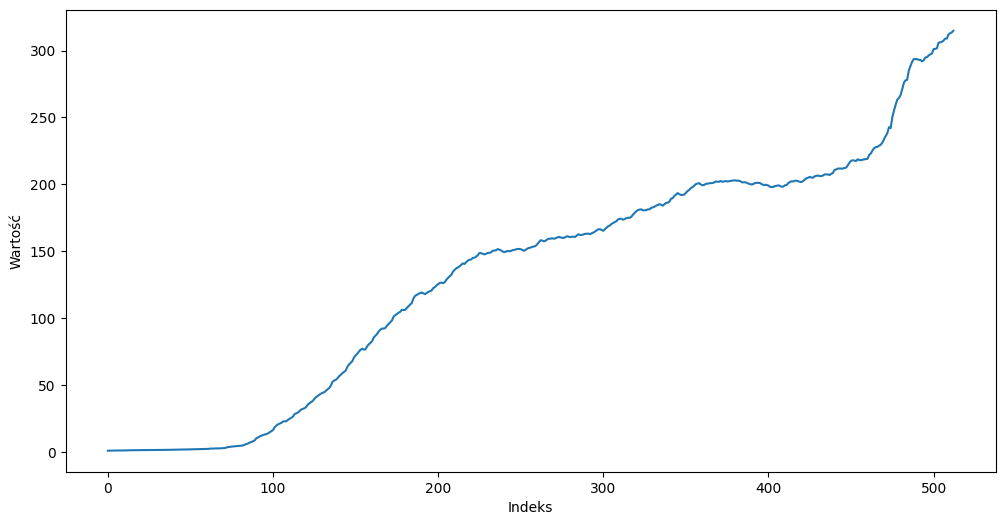

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(data_to_learn)), data_to_learn[:,1])
ax.set_xlabel("Indeks")
ax.set_ylabel("Wartość")
plt.show()

## Konwersja danych - od indeksu 150 bez outlinerów


In [14]:
data_150 = data_array[149:]
data_to_learn = np.zeros((len(data_150), 2))

absolute_result = 1.0
idx = 0

for i, row in enumerate(data_150):
    year = int(row[0])
    month = int(row[1])
    if i > 0:
        absolute_result += absolute_result * ((float(row[2]) - 100.0) / 100.0)
    data_to_learn[idx] = [(year - 1982) * 12 + month, absolute_result]
    idx += 1

In [15]:
len(data_to_learn)

364

# 1 - model sekwencyjny

In [16]:
# Parametry modelu
WINDOW_SIZE = 6
TRAIN_RATIO = 0.8
FEATURES = 1  # jedna cecha: inflacja

scaler = MinMaxScaler(feature_range=(0, 1))
inflation_scaled = scaler.fit_transform(data_to_learn[:, 1].reshape(-1, 1))
data_scaled = np.hstack((data_to_learn[:, 0].reshape(-1, 1), inflation_scaled))

# model uczy sie na sekwencji poprzednich wartosci i przewiduje kolejną
def prepare_data_seq(data, window_size):
    '''
    Przygotowuje sekwencje danych do modelowania sekwencyjnego,
    dzieląc dane na sekwencje cech i odpowiadające im wartości docelowe.
    '''
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 1])
        y.append(data[i+window_size, 1])
    return np.array(X), np.array(y)

In [17]:
X, y = prepare_data_seq(data_scaled, WINDOW_SIZE)

n_train = int(len(X) * TRAIN_RATIO)
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

X_train = X_train.reshape((X_train.shape[0], WINDOW_SIZE, FEATURES))
X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, FEATURES))

In [18]:
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(WINDOW_SIZE, FEATURES)),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

# --- Trening modelu ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1736 - val_loss: 0.0617
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148 - val_loss: 3.3390e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - val_loss: 0.0075
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 9.7947e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - val_loss: 9.2633e-05
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 1.6288e-05
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - val_loss: 5.2382e-04
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 1.0650e-04
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss:

In [19]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)       # odwrotny scaling
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


In [20]:
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f"RMSE na zbiorze testowym: {rmse:.4f}")

RMSE na zbiorze testowym: 0.0784


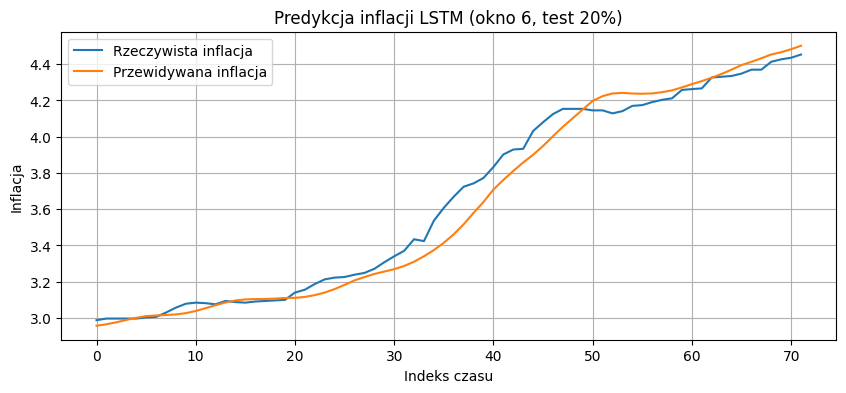

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_actual, label='Rzeczywista inflacja')
plt.plot(y_pred, label='Przewidywana inflacja')
plt.title(f'Predykcja inflacji LSTM (okno {WINDOW_SIZE}, test {100-TRAIN_RATIO*100:.0f}%)')
plt.xlabel('Indeks czasu')
plt.ylabel('Inflacja')
plt.legend()
plt.grid(True)
plt.show()

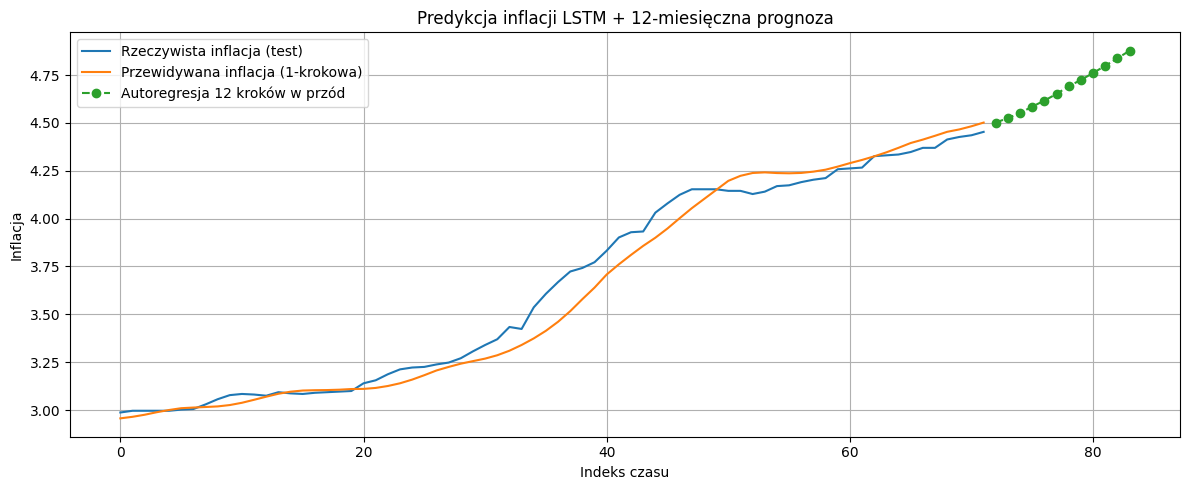

In [22]:
future_steps = 12
last_seq = X_test[-1]
predictions = []

for _ in range(future_steps):
    pred = model.predict(last_seq.reshape(1, WINDOW_SIZE, FEATURES), verbose=0)
    predictions.append(pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[-1] = pred[0, 0]

# Inwersja skalowania predykcji przyszłych
predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Zakładamy, że predykcje przyszłe następują bezpośrednio po ostatnim znanym punkcie
start_idx = len(y_test_actual)
x_future = np.arange(start_idx, start_idx + future_steps)


In [23]:
# Trenowanie na pełnych danych
X_all, y_all = prepare_data_seq(data_scaled, WINDOW_SIZE)
X_all = X_all.reshape((X_all.shape[0], WINDOW_SIZE, FEATURES))

model_full = Sequential([
    LSTM(50, activation='tanh', input_shape=(WINDOW_SIZE, FEATURES)),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model_full.compile(optimizer='adam', loss='mse')

early_stop_full = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history_full = model_full.fit(
    X_all, y_all,
    epochs=50,
    batch_size=16,
    callbacks=[early_stop_full],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1213
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0120
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 16/50
23/23 ━━━━━━━━━━━━

In [24]:
# Predykcja 12 miesięcy do przodu z pełnego modelu
future_steps_full = 12
last_seq_full = X_all[-1]
predictions_full = []

for _ in range(future_steps_full):
    pred = model_full.predict(last_seq_full.reshape(1, WINDOW_SIZE, FEATURES), verbose=0)
    predictions_full.append(pred[0, 0])
    last_seq_full = np.roll(last_seq_full, -1)
    last_seq_full[-1] = pred[0, 0]

predictions_full_unscaled = scaler.inverse_transform(np.array(predictions_full).reshape(-1, 1))


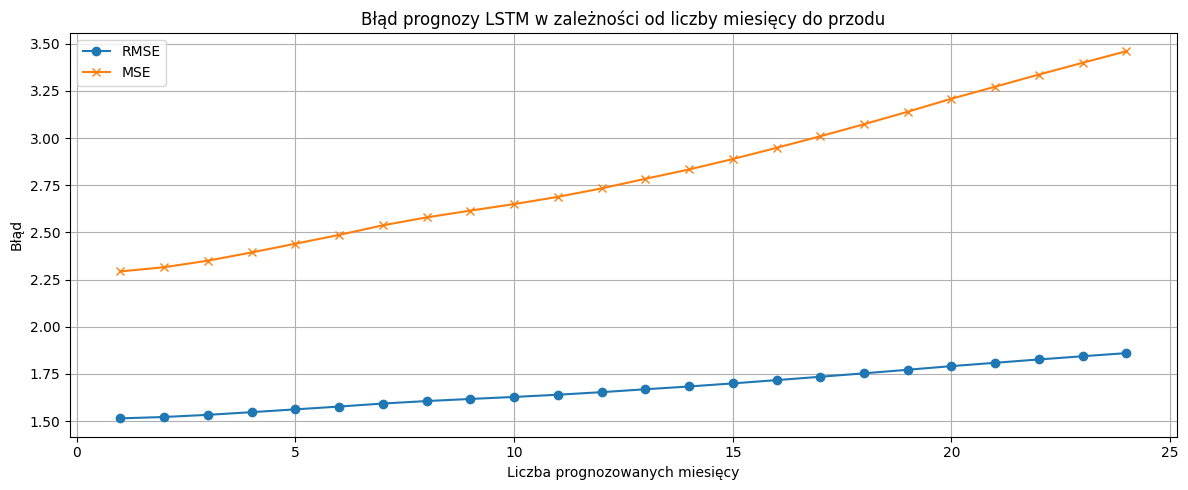

In [26]:
import numpy as np
import matplotlib.pyplot as plt

max_steps = 24  # testujemy od 1 do 24 miesięcy
mse_list = []
rmse_list = []

last_seq_eval = X_test[-1].copy()

for steps in range(1, max_steps + 1):
    temp_seq = last_seq_eval.copy()
    preds = []

    for _ in range(steps):
        pred = model.predict(temp_seq.reshape(1, WINDOW_SIZE, FEATURES), verbose=0)
        preds.append(pred[0, 0])
        temp_seq = np.roll(temp_seq, -1)
        temp_seq[-1] = pred[0, 0]

    preds_unscaled = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

    # Rzeczywiste wartości do porównania — bierzemy tyle samo z końca testowego zestawu
    actual = y_test_actual[:steps]
    actual = actual.reshape(-1, 1)

    mse = mean_squared_error(actual, preds_unscaled)
    rmse = np.sqrt(mse)

    mse_list.append(mse)
    rmse_list.append(rmse)

# Rysowanie wykresu
plt.figure(figsize=(12, 5))
plt.plot(range(1, max_steps + 1), rmse_list, marker='o', label='RMSE')
plt.plot(range(1, max_steps + 1), mse_list, marker='x', label='MSE')
plt.title("Błąd prognozy LSTM w zależności od liczby miesięcy do przodu")
plt.xlabel("Liczba prognozowanych miesięcy")
plt.ylabel("Błąd")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

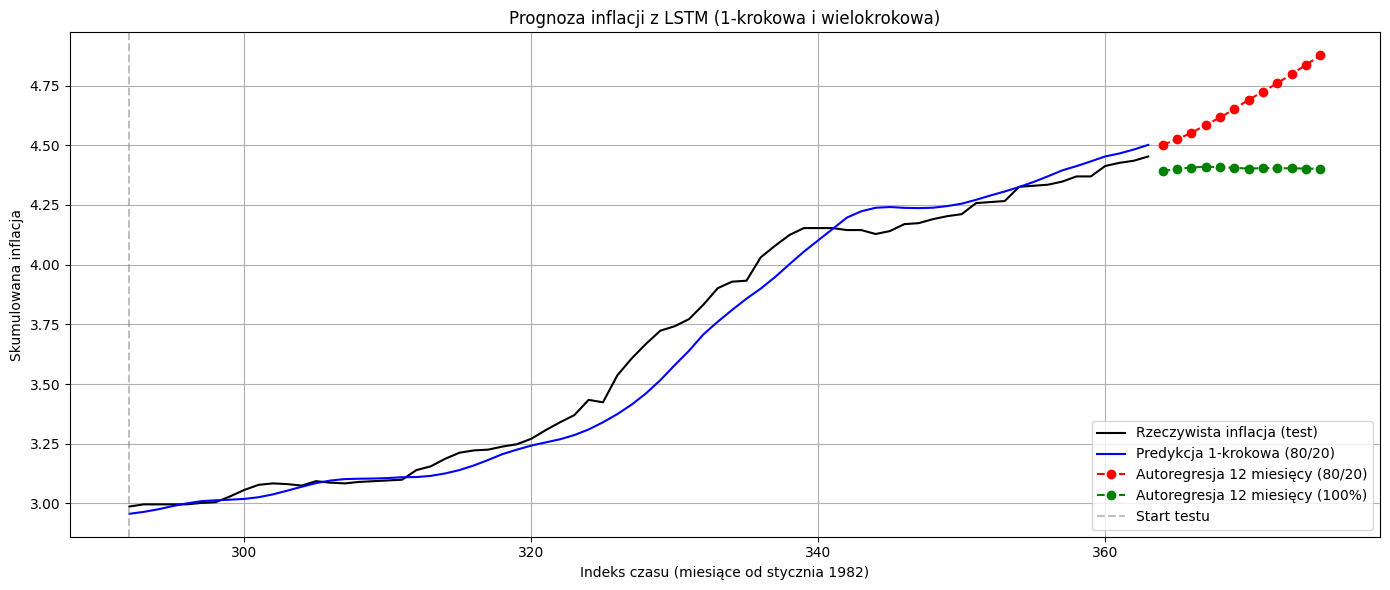

In [25]:
plt.figure(figsize=(14, 6))

# Indeksy czasowe:
test_start_idx = len(data_scaled) - len(y_test_actual)
test_end_idx = len(data_scaled)
future_start_idx = test_end_idx
future_end_idx = future_start_idx + future_steps
full_future_start_idx = len(data_scaled)
full_future_end_idx = full_future_start_idx + future_steps_full

# Oś czasu dla testu
x_test = np.arange(test_start_idx, test_end_idx)
x_pred = np.arange(test_start_idx, test_start_idx + len(y_pred))
x_future = np.arange(future_start_idx, future_end_idx)
x_full_future = np.arange(full_future_start_idx, full_future_end_idx)

# Wykresy
plt.plot(x_test, y_test_actual, label='Rzeczywista inflacja (test)', color='black')
plt.plot(x_pred, y_pred, label='Predykcja 1-krokowa (80/20)', color='blue')
plt.plot(x_future, predictions_unscaled, '--o', label='Autoregresja 12 miesięcy (80/20)', color='red')
plt.plot(x_full_future, predictions_full_unscaled, '--o', label='Autoregresja 12 miesięcy (100%)', color='green')

# Linia oddzielająca dane uczące/testowe
plt.axvline(x=test_start_idx, color='gray', linestyle='--', alpha=0.5, label='Start testu')

plt.title('Prognoza inflacji z LSTM (1-krokowa i wielokrokowa)')
plt.xlabel('Indeks czasu (miesiące od stycznia 1982)')
plt.ylabel('Skumulowana inflacja')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
